In [66]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
import typing

$$
\begin{aligned}
S_j(x)&=a_j+b_j(x-x_j)+c_j(x-x_j)^2+d_j(x-x_j)^3 \\
S'_j(x)&=b_j+c_j2(x-x_j)+d_j3(x-x_j)^2\\
S''_j(x)&=c_j2+d_j6(x-x_j)\\
\end{aligned}
$$

$$
\begin{aligned}
S_0(x_0)&=f(x_0)\\
S_0(x_1)&=f(x_1)\\
S_1(x_1)&=f(x_1)\\
S_1(x_2)&=f(x_2)\\
&\vdots\\
\\
S'_0(x_1)&=S'_1(x_1)\\
\Leftrightarrow b_0+2c_0(x_1-x_0)+3d_0(x_1-x_0)^2&=b_1\\
S''_0(x_1)&=S''_1(x_1)\\
\Leftrightarrow 2c_0+6d_0(x_1-x_0)&=2c_1\\
\\
\end{aligned}
$$

In [20]:
def same(*args):
    for arg in args:
        assert args[0] == arg
    return args[0]

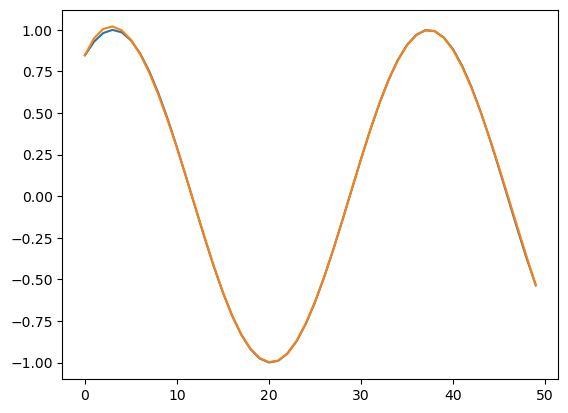

In [79]:
def s(xj, x):
    return np.array([1, (x-xj), (x-xj)**2, (x-xj)**3])


def sd(xj, x):
    return np.array([0, 1, 2*(x-xj), 3*(x-xj)**2])


def sdd(xj, x):
    return np.array([0, 0, 2, 6*(x-xj)])


def sddd(xj, x):
    return np.array([0, 0, 0, 6])


class Spline:
    def __init__(
        self,
        x: np.ndarray,
        y: np.ndarray,
        yd: np.ndarray,
        ydd: np.ndarray,
        *,
        kind: typing.Literal["clamped", "natural_1", "natural_2", "deboor"],
    ):
        assert kind in {"clamped", "natural_1", "natural_2", "deboor"}
        same(1, len(x.shape), len(y.shape), len(yd.shape), len(ydd.shape))
        n = same(len(x), len(y), len(yd), len(ydd))

        polys_no = n-1
        eqs_no = polys_no*4
        A = scipy.sparse.dok_array((eqs_no, eqs_no))
        b = np.zeros(eqs_no)

        eqs_iter = iter(range(eqs_no))

        match kind:
            case "natural_1":
                eqi = next(eqs_iter)
                A[eqi, 0*4:(0+1)*4] = sd(x[0], x[0])
                b[eqi] = 0
                
                eqi = next(eqs_iter)
                A[eqi, (polys_no-1)*4:(polys_no-1+1)*4] = sd(x[polys_no-1], x[polys_no])
                b[eqi] = 0
            case "natural_2":
                eqi = next(eqs_iter)
                A[eqi, 0*4:(0+1)*4] = sdd(x[0], x[0])
                b[eqi] = 0
                
                eqi = next(eqs_iter)
                A[eqi, (polys_no-1)*4:(polys_no-1+1)*4] = sdd(x[polys_no-1], x[polys_no])
                b[eqi] = 0
            case "clamped":
                eqi = next(eqs_iter)
                A[eqi, 0*4:(0+1)*4] = sd(x[0], x[0])
                b[eqi] = yd[0]
                
                eqi = next(eqs_iter)
                A[eqi, (polys_no-1)*4:(polys_no-1+1)*4] = sd(x[polys_no-1], x[polys_no])
                b[eqi] = yd[polys_no]
            case "deboor":
                eqi = next(eqs_iter)
                A[eqi, 0*4:(0+2)*4] = np.concatenate(
                    (sddd(x[0], x[0]), -sddd(x[1], x[0]))
                )
                b[eqi] = 0
                
                eqi = next(eqs_iter)
                A[eqi, (polys_no-2)*4:(polys_no-2+2)*4] = np.concatenate(
                    (sddd(x[polys_no-2], x[polys_no]), -sddd(x[polys_no-1], x[polys_no]))
                )
                b[eqi] = 0
        
        for i in range(polys_no):
            eqi = next(eqs_iter)
            A[eqi, i*4:(i+1)*4] = s(x[i], x[i])
            b[eqi] = y[i]

            eqi = next(eqs_iter)
            A[eqi, i*4:(i+1)*4] = s(x[i], x[i+1])
            b[eqi] = y[i+1]

        for i in range(polys_no-1):
            eqi = next(eqs_iter)
            A[eqi, i*4:(i+2)*4] = np.concatenate((sd(x[i], x[i+1]), -sd(x[i+1], x[i+1])))
            b[eqi] = 0
            
            eqi = next(eqs_iter)
            A[eqi, i*4:(i+2)*4] = np.concatenate((sdd(x[i], x[i+1]), -sdd(x[i+1], x[i+1])))
            b[eqi] = 0

        A = A.tocsr()
        coef = scipy.sparse.linalg.spsolve(A, b)
        coef = coef.reshape(-1, 4)
        
        self.polys_no = polys_no
        self.nodes = x.copy()
        self.coef = coef

    def eval(self, x):
        poly_i = np.searchsorted(self.nodes, x)-1
        assert np.min(poly_i) >= 0 and np.max(poly_i) < self.polys_no

        xj = self.nodes[poly_i]
        coef = self.coef[poly_i]

        res = np.sum(
            (
                (x - xj).reshape(-1, 1) ** np.arange(4)
                *
                coef
            ),
            axis=1,
        )
        return res


x = np.linspace(1, 10, 10)
points = np.linspace(1+0.01, 10-0.01)
y = np.sin(x)
yd = np.cos(x)
ydd = -np.sin(x)
spline = Spline(x, y, yd, ydd, kind="deboor")

plt.plot(np.sin(points))

p = spline.eval(points)
plt.plot(p)

# Probleme

natural_1
[ 0.84839635  0.94990565  1.00593447  1.02043609  0.99736377  0.94067078
  0.85431039  0.74223587  0.60840048  0.45675749  0.29126018  0.11586292
 -0.06489862 -0.24495717 -0.41799615 -0.57769902 -0.71774921 -0.83210039
 -0.91764911 -0.97310022 -0.99718496 -0.98863452 -0.94619161 -0.87034356
 -0.76517508 -0.63521499 -0.48499211 -0.31903526 -0.14200324  0.04039222
  0.22192873  0.39638056  0.55752196  0.69914734  0.81643491  0.90681481
  0.96792398  0.99739934  0.99287784  0.95270902  0.87962061  0.77800197
  0.65224568  0.50674429  0.34589038  0.17407651 -0.00430477 -0.18486089
 -0.36319928 -0.53492739]


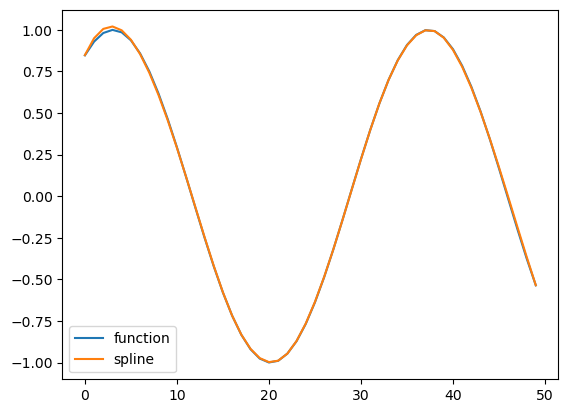

natural_2
[ 0.84839635  0.94990565  1.00593447  1.02043609  0.99736377  0.94067078
  0.85431039  0.74223587  0.60840048  0.45675749  0.29126018  0.11586292
 -0.06489862 -0.24495717 -0.41799615 -0.57769902 -0.71774921 -0.83210039
 -0.91764911 -0.97310022 -0.99718496 -0.98863452 -0.94619161 -0.87034356
 -0.76517508 -0.63521499 -0.48499211 -0.31903526 -0.14200324  0.04039222
  0.22192873  0.39638056  0.55752196  0.69914734  0.81643491  0.90681481
  0.96792398  0.99739934  0.99287784  0.95270902  0.87962061  0.77800197
  0.65224568  0.50674429  0.34589038  0.17407651 -0.00430477 -0.18486089
 -0.36319928 -0.53492739]


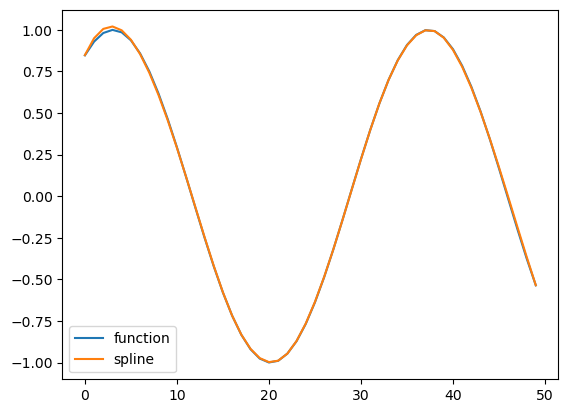

clamped
[ 0.84839635  0.94990565  1.00593447  1.02043609  0.99736377  0.94067078
  0.85431039  0.74223587  0.60840048  0.45675749  0.29126018  0.11586292
 -0.06489862 -0.24495717 -0.41799615 -0.57769902 -0.71774921 -0.83210039
 -0.91764911 -0.97310022 -0.99718496 -0.98863452 -0.94619161 -0.87034356
 -0.76517508 -0.63521499 -0.48499211 -0.31903526 -0.14200324  0.04039222
  0.22192873  0.39638056  0.55752196  0.69914734  0.81643491  0.90681481
  0.96792398  0.99739934  0.99287784  0.95270902  0.87962061  0.77800197
  0.65224568  0.50674429  0.34589038  0.17407651 -0.00430477 -0.18486089
 -0.36319928 -0.53492739]


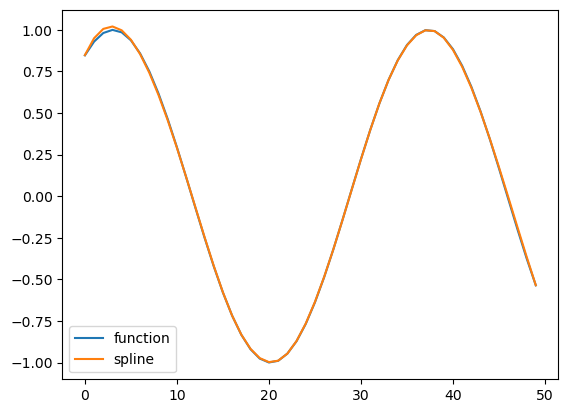

deboor
[ 0.84839635  0.94990565  1.00593447  1.02043609  0.99736377  0.94067078
  0.85431039  0.74223587  0.60840048  0.45675749  0.29126018  0.11586292
 -0.06489862 -0.24495717 -0.41799615 -0.57769902 -0.71774921 -0.83210039
 -0.91764911 -0.97310022 -0.99718496 -0.98863452 -0.94619161 -0.87034356
 -0.76517508 -0.63521499 -0.48499211 -0.31903526 -0.14200324  0.04039222
  0.22192873  0.39638056  0.55752196  0.69914734  0.81643491  0.90681481
  0.96792398  0.99739934  0.99287784  0.95270902  0.87962061  0.77800197
  0.65224568  0.50674429  0.34589038  0.17407651 -0.00430477 -0.18486089
 -0.36319928 -0.53492739]


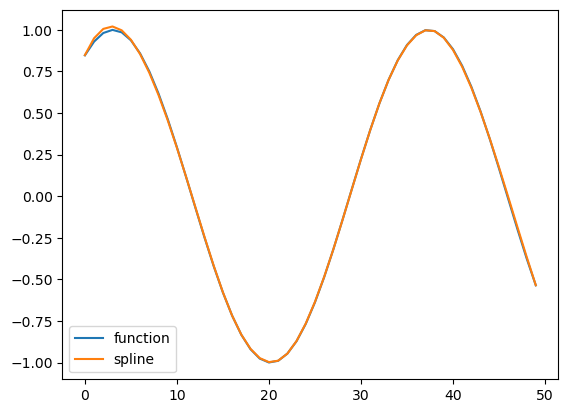

In [84]:
x = np.linspace(1, 10, 10)
points = np.linspace(1+0.01, 10-0.01)
y = np.sin(x)
yd = np.cos(x)
ydd = -np.sin(x)
for kind in [
    "natural_1",
    "natural_2",
    "clamped",
    "deboor",
]:
    plt.figure()
    
    plt.plot(np.sin(points))
    
    spline = Spline(x, y, yd, ydd, kind="deboor")
    p = spline.eval(points)
    print(kind)
    print(p)
    plt.plot(p)

    plt.legend(["function", "spline"])
    
    plt.show()